## Richter's Predictor: Modeling Earthquake Damage

https://www.drivendata.org/competitions/57/nepal-earthquake

Este simple código otorga un F1 de 0.737, suficiente para ubicarse dentro del 10% de la competencia y bastante cercano al primer lugar (F1=0.756).

Tanto el código como los comentarios se encuentran actualmente en desarrollo.

In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

root = os.path.abspath('D:\drivendata\earthquake\data')
train_y=DB = pd.read_csv(os.path.join(root + '/train_labels.csv'))
train_x=DB = pd.read_csv(os.path.join(root + '/train_values.csv'))

Primero realizamos un análisis preliminar sobre las variables

In [2]:
train_x.nunique()

building_id                               260601
geo_level_1_id                                31
geo_level_2_id                              1414
geo_level_3_id                             11595
count_floors_pre_eq                            9
age                                           42
area_percentage                               84
height_percentage                             27
land_surface_condition                         3
foundation_type                                5
roof_type                                      3
ground_floor_type                              5
other_floor_type                               4
position                                       4
plan_configuration                            10
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_superstructure_stone_flag                  2
has_superstructure_cement_mortar_stone         2
has_superstructure_mud_mortar_brick            2
has_superstructure_c

In [3]:
train_x.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

Definimos variables según su naturaleza (numérica, categórica o binaria)

In [4]:
num_cols=['count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage',
'count_families'
]

In [5]:
OHE_cols=[#'building_id',
#'geo_level_3_id',
'geo_level_2_id',
'geo_level_1_id',
'plan_configuration',
'foundation_type',
'ground_floor_type',
'other_floor_type',
'position',
'legal_ownership_status',
'land_surface_condition',
'roof_type'
]

In [6]:
bool_cols=['has_superstructure_adobe_mud',
'has_superstructure_mud_mortar_stone',
'has_superstructure_stone_flag',
'has_superstructure_cement_mortar_stone',
'has_superstructure_mud_mortar_brick',
'has_superstructure_cement_mortar_brick',
'has_superstructure_timber',
'has_superstructure_bamboo',
'has_superstructure_rc_non_engineered',
'has_superstructure_rc_engineered',
'has_superstructure_other',
'has_secondary_use',
'has_secondary_use_agriculture',
'has_secondary_use_hotel',
'has_secondary_use_rental',
'has_secondary_use_institution',
'has_secondary_use_school',
'has_secondary_use_industry',
'has_secondary_use_health_post',
'has_secondary_use_gov_office',
'has_secondary_use_use_police',
'has_secondary_use_other'
]


In [7]:
train_x[OHE_cols].nunique().sum()


1483

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')

In [9]:
enc.fit(train_x[OHE_cols])
OHE_nombres=enc.get_feature_names(train_x[OHE_cols].columns)
OHE_train_df=pd.DataFrame(enc.transform(train_x[OHE_cols]).toarray(),columns=OHE_nombres,dtype=int)
train_df=pd.DataFrame.join(train_x[num_cols+bool_cols],OHE_train_df)

In [10]:
train_y=train_y['damage_grade']
train_y=train_y-1

Por motivos de reproducibilidad agregamos una semilla arbitraria.

In [11]:
np.random.seed(999)

In [12]:
X_train, X_test, y_train, y_test=train_test_split(train_df,train_y,test_size=0.2,stratify=train_y)

In [13]:
train_data = lgb.Dataset(X_train , label = y_train, free_raw_data=False)

In [14]:
fake_valid_data = lgb.Dataset(X_test, label = y_test,
                 free_raw_data=False)

In [15]:
def lgb_f1_score(y_pred, dtrain):
    y_true = dtrain.get_label()    
    preds = y_pred.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds,average='micro'), True

In [16]:
params={"early_stopping_rounds":400, 
            "objective" : 'multiclass',
            "metric": 'multi_error',
            "learning_rate": 0.05,
            "min_data_in_leaf": 4,
            "boosting":'gbdt',
            "max_leaves": 300,
            "max_bin":600,
            'num_class': 3} 

In [17]:
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=50, num_boost_round=2000,feval=lgb_f1_score)


C:\Users\Francisco\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 1447
[LightGBM] [Info] Start training from score -2.339173
[LightGBM] [Info] Start training from score -0.564028
[LightGBM] [Info] Start training from score -1.094582
Training until validation scores don't improve for 400 rounds
[50]	valid_0's multi_error: 0.2711	valid_0's f1: 0.7289
[100]	valid_0's multi_error: 0.265805	valid_0's f1: 0.734195
[150]	valid_0's multi_error: 0.263425	valid_0's f1: 0.736575
[200]	valid_0's multi_error: 0.262716	valid_0's f1: 0.737284
[250]	valid_0's multi_error: 0.263195	valid_0's f1: 0.736805
[300]	valid_0's multi_error: 0.263637	valid_0's f1: 0.736363
[350]	valid_0's multi_error: 0.263099	valid_0's f1: 0.73

In [18]:
test_x=DB = pd.read_csv(os.path.join(root + '/test_values.csv'))
OHE_nombres=enc.get_feature_names(test_x[OHE_cols].columns)
OHE_test_df=pd.DataFrame(enc.transform(test_x[OHE_cols]).toarray(),columns=OHE_nombres,dtype=int)
test_df=pd.DataFrame.join(test_x[num_cols+bool_cols],OHE_test_df)

Hacemos un sanity check de la distribución de las proyecciones, si las poblaciones son similares debiesen ser porcentajes similares.

In [19]:
aux=m_lgb.predict(test_df)
aux.round().sum(axis=0)/aux.round().sum()

array([0.06887292, 0.65390413, 0.27722294])

In [20]:
aux2=m_lgb.predict(train_df)
aux2.round().sum(axis=0)/aux2.round().sum()


array([0.06977639, 0.65110624, 0.27911737])

In [21]:
pred_train=pd.DataFrame(aux2.argmax(axis=1))
print(f1_score(train_y, pred_train, average='micro'))
pred_test=pd.DataFrame(aux.argmax(axis=1),columns=['damage_grade'])+1

0.7734736244296837


In [22]:
submission=pd.concat([test_x['building_id'],pred_test],axis=1)
submission.to_csv('submission.csv',sep=",",index=False)

Por motivos de interpretabilidad, graficamos las variables más relevantes del modelo.

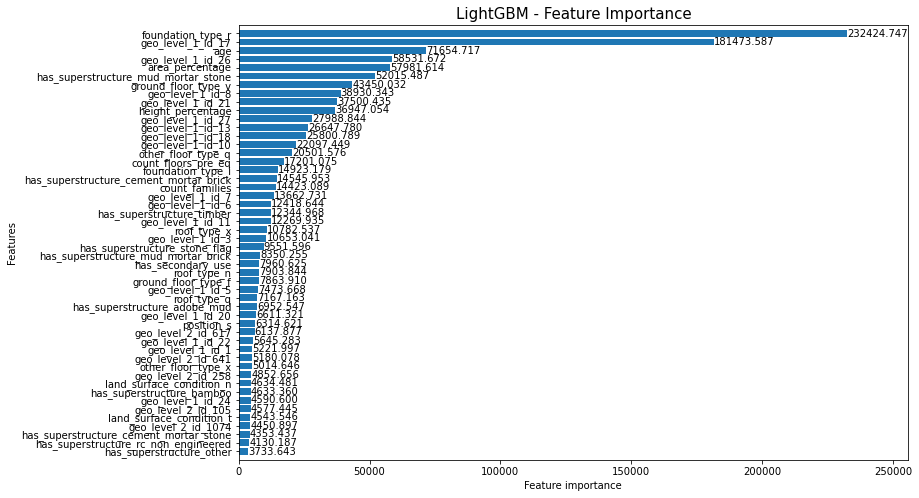

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 4)


fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax,importance_type='gain')
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

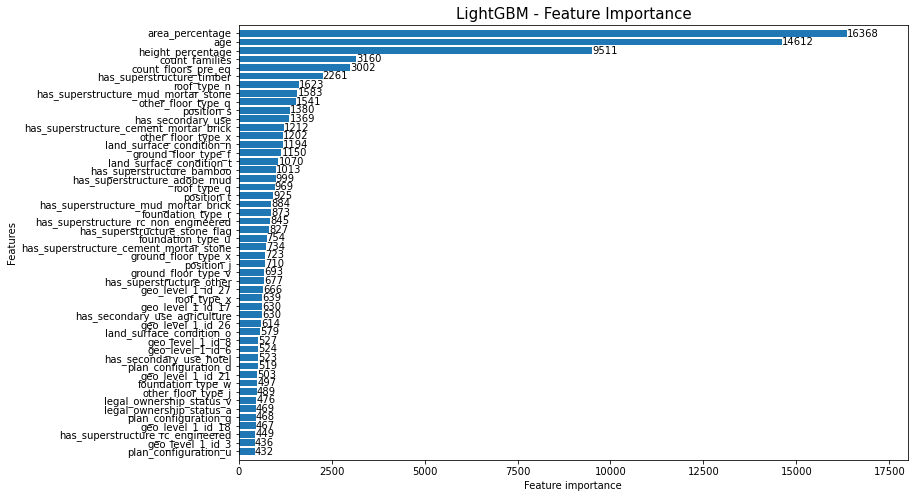

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax,importance_type='split')
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## En desarrollo